In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd

file_path = "/content/drive/MyDrive/Colab Notebooks/House Price Regression/"
# Load data
train_df = pd.read_csv(file_path + "train.csv")

# Quick overview
print(train_df.shape)

(1460, 81)


<h1>Cleaning data</h1>

In [ ]:
missing_values = train_df.isnull().sum().sort_values(ascending=False)
print(missing_values[missing_values > 0])

PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
MasVnrType       872
FireplaceQu      690
LotFrontage      259
GarageQual        81
GarageFinish      81
GarageType        81
GarageYrBlt       81
GarageCond        81
BsmtFinType2      38
BsmtExposure      38
BsmtCond          37
BsmtQual          37
BsmtFinType1      37
MasVnrArea         8
Electrical         1
dtype: int64


<h3>Filling Categorical Columns</h3>
For Categorical columns with lots of missing data, this is due to the dataset having NA mean the home doesn't have that feature, so I will fill these features with "None" as a placeholder for NA

*   For Garage Year Built, I am going to assume this is the same as year built
*   For Electrical, I am going to fill this value with the mode considering there is only one value missing.


In [ ]:
# Fill categorical
categorical_cols = ["MasVnrType", "FireplaceQu", "GarageQual", "GarageFinish",
                    "GarageType", "GarageCond", "BsmtFinType2", "BsmtExposure",
                    "BsmtCond", "BsmtQual", "BsmtFinType1", "PoolQC", "MiscFeature", "Alley", "Fence"]

train_df[categorical_cols] = train_df[categorical_cols].fillna("None")

# Fill GarageYrBlt
train_df["GarageYrBlt"] = train_df["GarageYrBlt"].fillna(train_df["YearBuilt"])

# Fill Electrical
train_df["Electrical"] = train_df["Electrical"].fillna(train_df["Electrical"].mode()[0])


<h3>Filling Numerical values</h3>

*   For LotFronage I am going to use the median value of in their neighborhood group because they are most likely similar

*   For Masonry Veneer Area I am going to fill NA values with 0

*   I am also going to add a feature TotalSD(Total Square Feet), HouseAge, and Remodel Age (Laste time it was remodeled)

In [ ]:
# Fill LotFrontage
train_df["LotFrontage"] = train_df.groupby("Neighborhood")["LotFrontage"].transform(lambda x: x.fillna(x.median()))

# Fill MasVnrArea
train_df["MasVnrArea"] = train_df["MasVnrArea"].fillna(0)

# Adding Feature Total Square Feet
train_df['TotalSF'] = train_df['GrLivArea'] + train_df['TotalBsmtSF']

# Adding Feature House Age
train_df['HouseAge'] = train_df['YrSold'] - train_df['YearBuilt']

# Adding Feature Remodel Age
train_df['RemodelAge'] = train_df['YrSold'] - train_df['YearRemodAdd']

print(train_df.isnull().sum().sum())

0


<h4>As you can see, the training data set now has no missing values and now I can Convert categorical features into numerical with one hot encoding</h4>

*   I will make 2 dataframes - one with categorical features and one with numerical features, excluding the target variable from these dataframes
*   Then I will one-hot encode the categorical features
*   Lastly, I am going to standardize the numerical values so that algorithms sensitive to scale will not be affected


In [ ]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler

categorical_features = train_df.select_dtypes(include=['object']).columns
numerical_features = train_df.select_dtypes(exclude=['object']).columns.drop('SalePrice')

# One-hot encoding
train_df = pd.get_dummies(train_df, columns=categorical_features, drop_first=True)
train_df = train_df.astype(int)

# Standardize
scaler = StandardScaler()
train_df[numerical_features] = scaler.fit_transform(train_df[numerical_features])


<h4> Now that the training set is all ready, I am going to apply the same changes to the test set</h4>

<h4> Now that there are no missing values in the dataset, I can now split the training data into training and validation sets, and train some models</h4>

In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV

# Features
X = train_df.drop(columns=['SalePrice'])

# Target
y = train_df['SalePrice']

# Split the data into training and validation sets (80% training, 20% validation)
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train[numerical_features] = scaler.fit_transform(X_train[numerical_features])
X_valid[numerical_features] = scaler.transform(X_valid[numerical_features])


In [ ]:
# prompt: get me the mean and standard deviation of the SalePrice Column

import pandas as pd

# Assuming 'train_df' is already loaded as in your provided code.
# If not, uncomment and adjust the file path below.
# from google.colab import drive
# drive.mount('/content/drive')
# file_path = "/content/drive/MyDrive/Colab Notebooks/House Price Regression/"
# train_df = pd.read_csv(file_path + "train.csv")

# Calculate mean and standard deviation of 'SalePrice'
mean_saleprice = train_df['SalePrice'].mean()
std_saleprice = train_df['SalePrice'].std()

print(f"Mean of SalePrice: {mean_saleprice}")
print(f"Standard Deviation of SalePrice: {std_saleprice}")


Mean of SalePrice: 180921.19589041095
Standard Deviation of SalePrice: 79442.50288288663


I am also going to score each models scores in an array, so I can compare them

In [ ]:
model_rmse_scores = {}
model_r2_scores = {}
model_mae_scores = {}
model_time_scores = {}

<h2> Linear Regression</h2>

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import time
import numpy as np

start_time_train = time.time()
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)
end_time_train = time.time()
lin_time = end_time_train - start_time_train

# Predict and Evaluate
y_valid_pred = linear_model.predict(X_valid)
lin_rmse = np.sqrt(mean_squared_error(y_valid, y_valid_pred))
lin_r2 = r2_score(y_valid, y_valid_pred)
lin_mae = mean_absolute_error(y_valid, y_valid_pred)

model_rmse_scores.update({'Linear': lin_rmse})
model_r2_scores.update({'Linear': lin_r2})
model_mae_scores.update({'Linear': lin_mae})
model_time_scores.update({'Linear': lin_time})

print(f"Root Mean Squared Error: {lin_rmse: .4f}")
print(f"R-squared: {lin_r2:.4f}")
print(f"Mean Absolute Error: {lin_mae:.4f}")
print(f"Training time:{lin_time:.4f}\n")

Root Mean Squared Error:  83215.7466
R-squared: 0.0972
Mean Absolute Error: 23965.9897
Training time:0.0606



Given that the r squared score on the linear regression is so low, I will not use this model.

<h2>Support Vector Regression</h2>

In [ ]:
from sklearn.svm import SVR
# AFter GridSearchCV best parameters
param_grid = {
    'kernel': ['poly'],
    'C': [1000],
    'epsilon': [1000],
    'gamma': ['scale'],
    'degree': [3],
    'coef0': [3]
}

start_time_train = time.time()
svr = SVR(kernel='poly', C=1000, epsilon=1000, gamma='scale', degree=3, coef0=3)
svr.fit(X_train, y_train)
end_time_train = time.time()
svr_time = end_time_train - start_time_train

svr_predictions = svr.predict(X_valid)
svr_rmse = np.sqrt(mean_squared_error(y_valid, svr_predictions))
svr_r2 = r2_score(y_valid, svr_predictions)
svr_mae = mean_absolute_error(y_valid, svr_predictions)
vector_count = svr.support_vectors_.shape[0]

model_rmse_scores.update({'SVR': svr_rmse})
model_r2_scores.update({'SVR': svr_r2})
model_mae_scores.update({'SVR': svr_mae})
model_time_scores.update({'SVR': svr_time})

print(f"Root Mean Squared Error: {svr_rmse: .4f}")
print(f"R-squared: {svr_r2:.4f}")
print(f"Mean Absolute Error: {svr_mae:.4f}")
print(f"Training time:{svr_time:.4f}\n")
print(f"Support Vector number:{vector_count}")

Root Mean Squared Error:  25644.7244
R-squared: 0.9143
Mean Absolute Error: 14830.1139
Training time:0.2693

Support Vector number:1105


<h2> Ridge Regression</h2>

In [ ]:
from sklearn.linear_model import Ridge
# I ran a GridSearchCV to find the best alpha
best_ridge = {'alpha': 10}

start_time_train = time.time()
ridge = Ridge(alpha=10)
ridge.fit(X_train, y_train)
end_time_train = time.time()
ridge_time = end_time_train - start_time_train

ridge_predictions = ridge.predict(X_valid)
ridge_rmse = np.sqrt(mean_squared_error(y_valid, ridge_predictions))
ridge_r2 = r2_score(y_valid, ridge_predictions)
ridge_mae = mean_absolute_error(y_valid, ridge_predictions)

model_rmse_scores.update({'Ridge Regression': ridge_rmse})
model_r2_scores.update({'Ridge Regression': ridge_r2})
model_mae_scores.update({'Ridge Regression': ridge_mae})
model_time_scores.update({'Ridge Regression': ridge_time})

print("Ridge Regression")
print(f"Root Mean Squared Error: {ridge_rmse:.4f}")
print(f"R-squared: {ridge_r2:.4f}\n")
print(f"Training time:{ridge_time:.4f}\n")

Ridge Regression
Root Mean Squared Error: 30604.8165
R-squared: 0.8779

Training time:0.0230



<h2> Lasso Regression</h2>

In [ ]:
from sklearn.linear_model import Lasso
# I ran a GridSearchCV to find the best alpha
best_lasso = {'alpha': 100}

start_time_train = time.time()
lasso = Lasso(max_iter=5000, alpha=100)
lasso.fit(X_train, y_train)
end_time_train = time.time()
lasso_time = end_time_train - start_time_train

lasso_predictions = lasso.predict(X_valid)
lasso_rmse = np.sqrt(mean_squared_error(y_valid, lasso_predictions))
lasso_r2 = r2_score(y_valid, lasso_predictions)
lasso_mae = mean_absolute_error(y_valid, lasso_predictions)

model_rmse_scores.update({'Lasso Regression': lasso_rmse})
model_r2_scores.update({'Lasso Regression': lasso_r2})
model_mae_scores.update({'Lasso Regression': lasso_mae})
model_time_scores.update({'Lasso Regression': lasso_time})

print("Lasso Regression")
print(f"Root Mean Squared Error: {lasso_rmse:.4f}")
print(f"R-squared: {lasso_r2:.4f}\n")

Lasso Regression
Root Mean Squared Error: 31256.6601
R-squared: 0.8726



A larger Alpha performed better with lasso regression due to the increase in bias and the model not overfitting the data.

<h2>Random Forest Regressor</h2>

I chose to go with the Random Forest Regressor because it is more robust and can avoid overfitting better than a single decision tree, which will be helpful for this dataset that doesn't have many records

In [ ]:
from sklearn.ensemble import RandomForestRegressor
# Running the Random Forest took very long with all of the parameters
# I had to test one estimator at a time
best_rf = {
    'n_estimators': [150],
    'max_depth': [30],
    'min_samples_split': [5],
    'min_samples_leaf': [1]
}

start_time_train = time.time()
rf = RandomForestRegressor(n_estimators=150, max_depth=30,
                           min_samples_split=5, min_samples_leaf=1,random_state=42)
rf.fit(X_train, y_train)
end_time_train = time.time()
rf_time = end_time_train - start_time_train

rf_predictions = rf.predict(X_valid)
rf_rmse = np.sqrt(mean_squared_error(y_valid, rf_predictions))
rf_r2 = r2_score(y_valid, rf_predictions)
rf_mae = mean_absolute_error(y_valid, rf_predictions)

model_rmse_scores.update({'Random Forest': rf_rmse})
model_r2_scores.update({'Random Forest': rf_r2})
model_mae_scores.update({'Random Forest': rf_mae})
model_time_scores.update({'Random Forest': rf_time})

print("Random Forest Regressor (GridSearchCV)")
print(f"Root Mean Squared Error: {rf_rmse:.4f}")
print(f"R-squared: {rf_r2:.4f}\n")
print(f"Training Runtime: {rf_time:.4f} seconds")

Random Forest Regressor (GridSearchCV)
Root Mean Squared Error: 30089.9626
R-squared: 0.8820

Training Runtime: 9.5498 seconds


<h2>XGBoost Regressor</h2>

We chose the XGBoost over the gradient boosting regressor because it is more advanced and supports parallel processing and regularization

In [ ]:
from xgboost import XGBRegressor
import time

# After running a GridSearchCV on the XGBoost regressor, these were the best parameters found
best_xgb = {
    'n_estimators': [1000],
    'learning_rate': [0.1],
    'max_depth': [3]
}
start_time_train = time.time()
xgb = XGBRegressor(n_estimators=1000, learning_rate=0.1, max_depth=3, random_state=42)
xgb.fit(X_train, y_train)
end_time_train = time.time()
xgb_time = end_time_train - start_time_train

xgb_predictions = xgb.predict(X_valid)
xgb_rmse = np.sqrt(mean_squared_error(y_valid, xgb_predictions))
xgb_r2 = r2_score(y_valid, xgb_predictions)
xgb_mae = mean_absolute_error(y_valid, xgb_predictions)


model_rmse_scores.update({'XGBoost': xgb_rmse})
model_r2_scores.update({'XGBoost': xgb_r2})
model_mae_scores.update({'XGBoost': xgb_mae})
model_time_scores.update({'XGBoost': xgb_time})

print("XGBoost Regressor ")
print(f"Root Mean Squared Error: {xgb_rmse:.4f}")
print(f"R-squared: {xgb_r2:.4f}\n")
print(f"Training Runtime: {xgb_time:.4f} seconds")


XGBoost Regressor 
Root Mean Squared Error: 26753.5657
R-squared: 0.9067

Training Runtime: 16.2176 seconds


<h2>Neural Network</h2>

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping


dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
dataset = dataset.cache()
tf.data.AUTOTUNE
dataset = dataset.batch(32)
dataset = dataset.prefetch(tf.data.AUTOTUNE)

start_time_train = time.time()
nn = keras.Sequential([
    keras.layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(1)  # Output layer
])
nn.compile(optimizer='adam', loss='mse')
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=60,
    restore_best_weights=True,
    verbose=1
)
best_weights_nn = nn.fit(
    X_train,
    y_train,
    epochs=600,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping]
)
end_time_train = time.time()
nn_time = end_time_train - start_time_train

# Predict and Evaluate Neural Network
nn_predictions = nn.predict(X_valid)
nn_rmse = np.sqrt(mean_squared_error(y_valid, nn_predictions))
nn_r2 = r2_score(y_valid, nn_predictions)
nn_mae = mean_absolute_error(y_valid, nn_predictions)

model_rmse_scores.update({'Neural Network': nn_rmse})
model_r2_scores.update({'Neural Network': nn_r2})
model_mae_scores.update({'Neural Network': nn_mae})
model_time_scores.update({'Neural Network': nn_time})

print(f"Root Mean Squared Error: {nn_rmse}")
print(f"R-squared: {nn_r2}")
print(f"Mean Absolute Error: {nn_mae}")
print(f"Training time:{nn_time:.4f}\n")

Epoch 1/600


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 40637509632.0000 - val_loss: 37839056896.0000
Epoch 2/600
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 40525266944.0000 - val_loss: 37825556480.0000
Epoch 3/600
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 38253420544.0000 - val_loss: 37786759168.0000
Epoch 4/600
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 38950551552.0000 - val_loss: 37702393856.0000
Epoch 5/600
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 37814575104.0000 - val_loss: 37553573888.0000
Epoch 6/600
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 40410853376.0000 - val_loss: 37318144000.0000
Epoch 7/600
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 39636238336.0000 - val_loss: 36980961280.0000
Epoch 8/600
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 37951889408.0000 - val_loss: 36521472000.0000
Epoch 9/600
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 36249477120.0000 - val_loss: 35915636736.0000
Epoch 10/600
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 374569

<h4>Ensemble Regressor</h4>

I also want to test an Ensemble model, which is the performance of our 6 models together(not linear regressor).

In [ ]:
# flatten neural network to be the same shape of the other regressors
nn_predictions = nn_predictions.flatten()

ensemble_predictions = (svr_predictions + ridge_predictions + lasso_predictions +
                 rf_predictions + xgb_predictions + nn_predictions) / 6

# Evaluate
ensemble_rmse = np.sqrt(mean_squared_error(y_valid, ensemble_predictions))
ensemble_r2 = r2_score(y_valid, ensemble_predictions)
ensemble_mae = mean_absolute_error(y_valid, ensemble_predictions)
ensemble_time = nn_time + svr_time + ridge_time + lasso_time + rf_time + xgb_time

model_rmse_scores.update({'Ensemble Regressor': ensemble_rmse})
model_r2_scores.update({'Ensemble Regressor': ensemble_r2})
model_mae_scores.update({'Ensemble Regressor': ensemble_mae})
model_time_scores.update({'Ensemble Regressor': ensemble_time})

print(f"Ensemble Model - Root Mean Squared Error: {ensemble_rmse:.4f}")
print(f"Ensemble Model - R-squared: {ensemble_r2:.4f}")
print(f"Ensemble Model - Mean Absolute Error: {ensemble_mae:.4f}")
print(f"Ensemble Model - Training time:{ensemble_time:.4f}\n")

Ensemble Model - Root Mean Squared Error: 27370.9801
Ensemble Model - R-squared: 0.9023
Ensemble Model - Mean Absolute Error: 15838.8533
Ensemble Model - Training time:155.2455



<h3>Comparing Results</h3>

Model Ranking (Lowest RMSE to Highest):
1. SVR: 25644.7244
2. XGBoost: 26753.5657
3. Ensemble Regressor: 27370.9801
4. Random Forest: 30089.9626
5. Ridge Regression: 30604.8165
6. Lasso Regression: 31256.6601
7. Neural Network: 32782.6920
8. Linear: 83215.7466


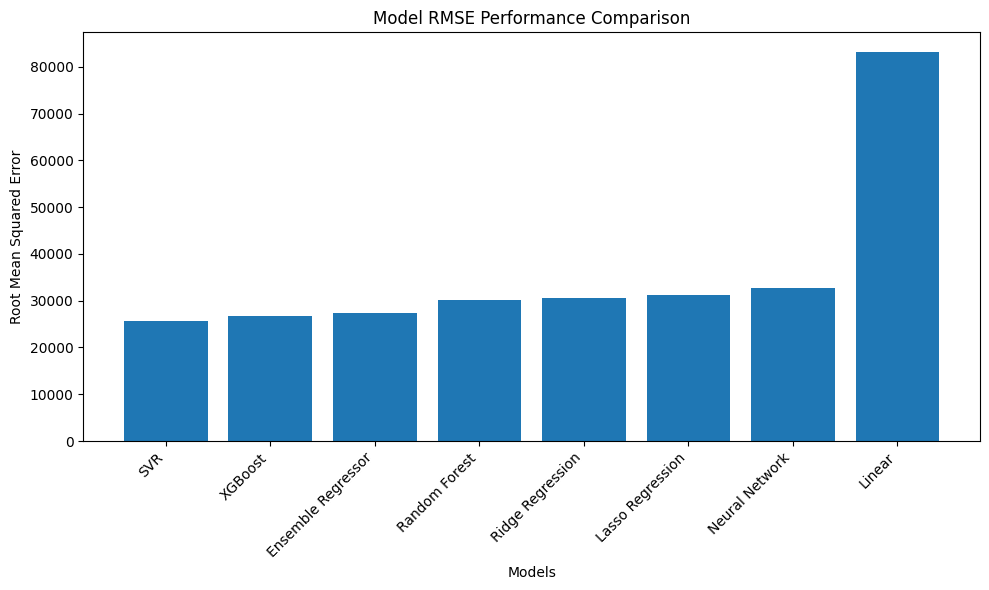

In [ ]:
import matplotlib.pyplot as plt

# Comparing the Models RMSE Scores
sorted_rmse_scores = dict(sorted(model_rmse_scores.items(), key=lambda item: item[1], reverse=False))

print("Model Ranking (Lowest RMSE to Highest):")
for i, (model, score) in enumerate(sorted_rmse_scores.items()):
  print(f"{i+1}. {model}: {score:.4f}")

plt.figure(figsize=(10, 6))
plt.bar(sorted_rmse_scores.keys(), sorted_rmse_scores.values())
plt.xlabel("Models")
plt.ylabel("Root Mean Squared Error")
plt.title("Model RMSE Performance Comparison")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

<h4>R-Squared</h4>

Model Ranking (Highest R-squared to Lowest):
1. SVR: 0.9143
2. XGBoost: 0.9067
3. Ensemble Regressor: 0.9023
4. Random Forest: 0.8820
5. Ridge Regression: 0.8779
6. Lasso Regression: 0.8726
7. Neural Network: 0.8599
8. Linear: 0.0972


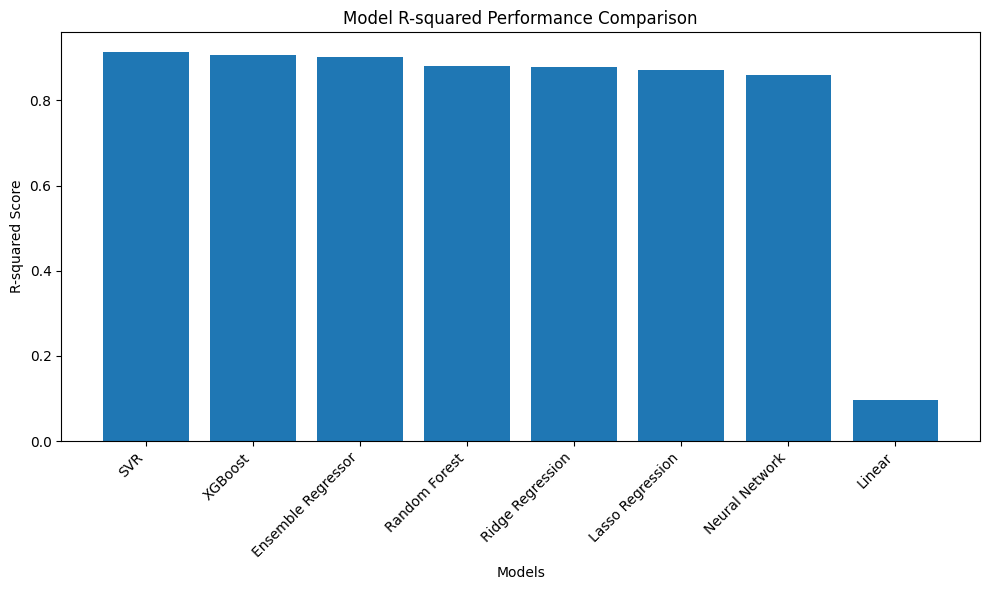

In [ ]:
# Comparing the Models R-Squared scores
sorted_r2_scores = dict(sorted(model_r2_scores.items(), key=lambda item: item[1], reverse=True))

print("Model Ranking (Highest R-squared to Lowest):")
for i, (model, score) in enumerate(sorted_r2_scores.items()):
  print(f"{i+1}. {model}: {score:.4f}")

plt.figure(figsize=(10, 6))
plt.bar(sorted_r2_scores.keys(), sorted_r2_scores.values())
plt.xlabel("Models")
plt.ylabel("R-squared Score")
plt.title("Model R-squared Performance Comparison")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

<h4>Mean Absolute Error</h4>

Model Ranking (Lowest MAE to Highest):
1. SVR: 14830.1139
2. Ensemble Regressor: 15838.8533
3. XGBoost: 16587.5898
4. Random Forest: 17928.9881
5. Lasso Regression: 18770.5251
6. Ridge Regression: 18957.2188
7. Neural Network: 20124.1230
8. Linear: 23965.9897


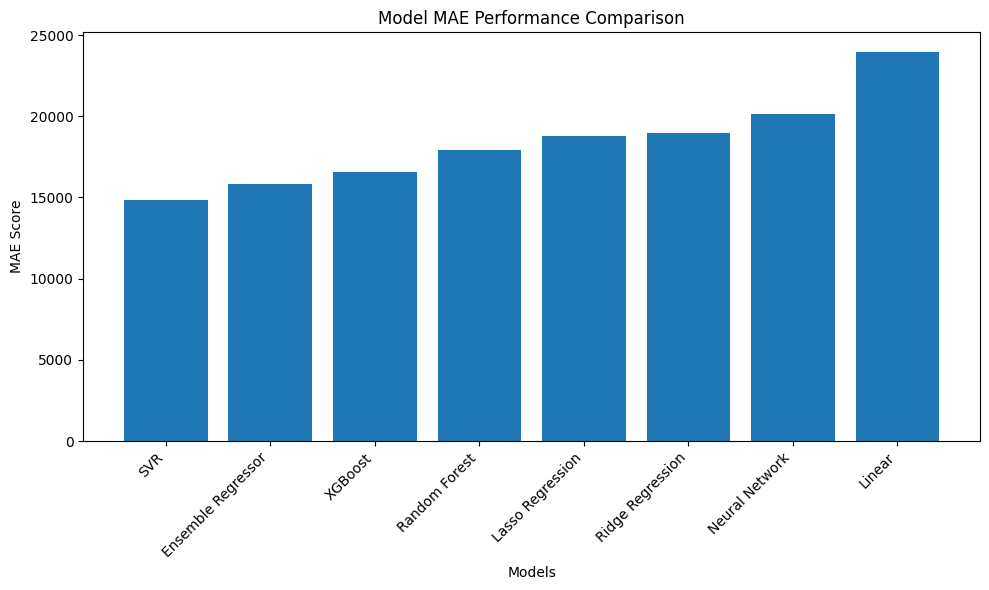

In [ ]:
# Comparing the Models MAE scores
sorted_mae_scores = dict(sorted(model_mae_scores.items(), key=lambda item: item[1], reverse=False))

print("Model Ranking (Lowest MAE to Highest):")
for i, (model, score) in enumerate(sorted_mae_scores.items()):
  print(f"{i+1}. {model}: {score:.4f}")

plt.figure(figsize=(10, 6))
plt.bar(sorted_mae_scores.keys(), sorted_mae_scores.values())
plt.xlabel("Models")
plt.ylabel("MAE Score")
plt.title("Model MAE Performance Comparison")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

<h4>Time</h4>

Model Ranking (Lowest time to Highest):
1. Ridge Regression: 0.0230
2. Linear: 0.0606
3. Lasso Regression: 0.1387
4. SVR: 0.2693
5. Random Forest: 9.5498
6. XGBoost: 16.2176
7. Neural Network: 129.0471
8. Ensemble Regressor: 155.2455


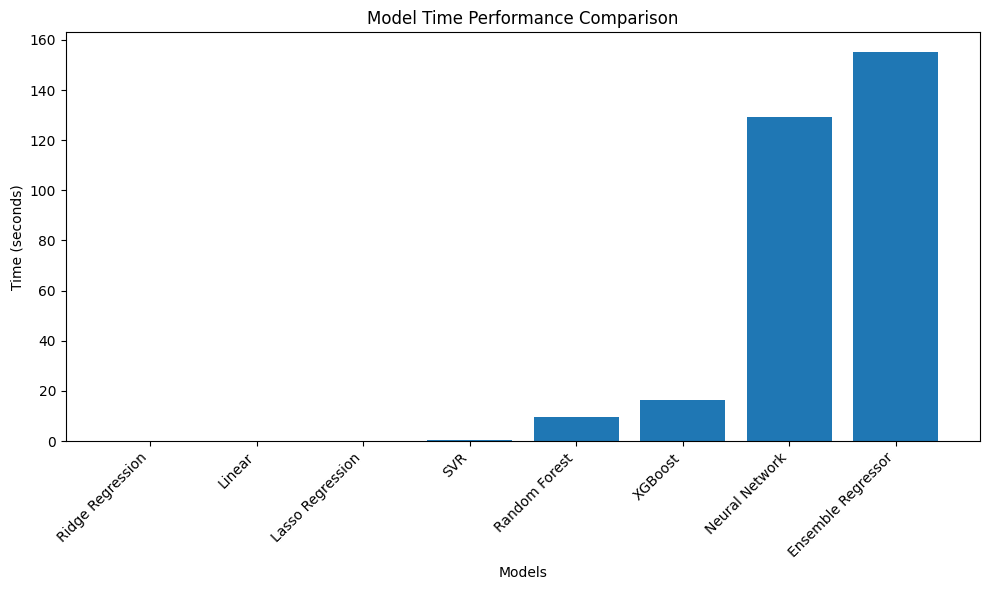

In [ ]:
# Comparing the Models Time scores
sorted_time_scores = dict(sorted(model_time_scores.items(), key=lambda item: item[1], reverse=False))

print("Model Ranking (Lowest time to Highest):")
for i, (model, score) in enumerate(sorted_time_scores.items()):
  print(f"{i+1}. {model}: {score:.4f}")

plt.figure(figsize=(10, 6))
plt.bar(sorted_time_scores.keys(), sorted_time_scores.values())
plt.xlabel("Models")
plt.ylabel("Time (seconds)")
plt.title("Model Time Performance Comparison")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.model_selection import cross_val_score
svr = SVR(kernel='poly', C=10000, epsilon=15000, gamma='scale', degree=3, coef0=3)

cv_rmse_scores = {}
cv_r2_scores = {}
cv_mae_scores = {}
cv_time_scores = {}
# Perform cross-validation
n_folds =[20, 50, 100, 200]
for fold in n_folds:
  start_time_cv = time.time()
  rmse_scores = cross_val_score(svr, X_train, y_train, cv=fold, scoring='neg_root_mean_squared_error')
  rmse_scores = -rmse_scores
  r2_scores = cross_val_score(svr, X_train, y_train, cv=fold, scoring='r2')
  mae_scores = cross_val_score(svr, X_train, y_train, cv=fold, scoring='neg_mean_absolute_error')
  mae_scores = -mae_scores
  end_time_cv = time.time()
  runtime_cv = end_time_cv - start_time_cv

  cv_rmse_scores[f'{fold} folds'] = rmse_scores
  cv_r2_scores[f'{fold} folds'] = r2_scores
  cv_mae_scores[f'{fold} folds'] = mae_scores
  cv_time_scores[f'{fold} folds'] = runtime_cv

  print(f"SVR Cross-Validation Performance for {fold} folds:")
  print(f"Mean RMSE: {np.mean(rmse_scores):.4f}")
  print(f"Mean R2: {np.mean(r2_scores):.4f}")
  print(f"Mean MAE: {np.mean(mae_scores):.4f}")
  print(f"Runtime: {runtime_cv:.2f} seconds")


SVR Cross-Validation Performance for 20 folds:
Mean RMSE: 26749.2751
Mean R2: 0.8231
Mean MAE: 15688.6787
Runtime: 11.33 seconds
SVR Cross-Validation Performance for 50 folds:
Mean RMSE: 24362.3007
Mean R2: 0.7899
Mean MAE: 15510.4033
Runtime: 33.46 seconds
SVR Cross-Validation Performance for 100 folds:
Mean RMSE: 22610.6342
Mean R2: 0.7743
Mean MAE: 15436.3025
Runtime: 65.69 seconds
SVR Cross-Validation Performance for 200 folds:
Mean RMSE: 20788.4417
Mean R2: 0.6651
Mean MAE: 15401.4833
Runtime: 134.67 seconds


As I increased the amount of folds in the set, all metrics improved except for the runtime and r-squared, leading me to believe a model with a higher bias may perform better. Now I would increase the amount of folds much more, however I do not have the computational power for that.

In [ ]:
mean_target = np.mean(y_train)
std_target = np.std(y_train)

print(f"Mean house price: {mean_target:.2f}")
print(f"Standard deviation of house prices: {std_target:.2f}")

Mean house price: 181441.54
Standard deviation of house prices: 77230.50


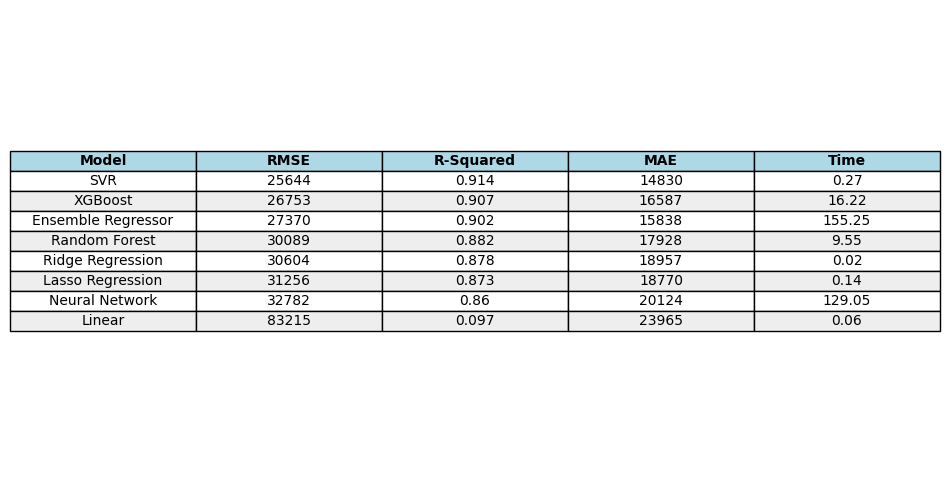

In [ ]:

model_scores = pd.DataFrame({
    'Model': list(model_rmse_scores.keys()),
    'RMSE': list(model_rmse_scores.values()),
    'R-Squared': list(model_r2_scores.values()),
    'MAE': list(model_mae_scores.values()),
    'Time': list(model_time_scores.values())
})

# Sort by RMSE
model_scores = model_scores.sort_values('RMSE')
model_scores['RMSE'] = model_scores['RMSE'].astype(int)
model_scores['MAE'] = model_scores['MAE'].astype(int)
model_scores['Time'] = model_scores['Time'].round(2)
model_scores['R-Squared'] = model_scores['R-Squared'].round(3)

fig, ax = plt.subplots(figsize=(10, 6))
ax.axis('off')
the_table = ax.table(cellText=model_scores.values,
                    colLabels=model_scores.columns,
                    loc='center',
                    cellLoc='center')

the_table.auto_set_font_size(False)
the_table.set_fontsize(10)
the_table.scale(1.2, 1.2)

for (row, col), cell in the_table.get_celld().items():
  if row == 0:
    cell.set_text_props(weight='bold', color='black')
    cell.set_facecolor('#ADD8E6')

for i in range(1, len(model_scores)):
  if i % 2 == 1:
    for (row, col), cell in the_table.get_celld().items():
        if row == i + 1:
            cell.set_facecolor('#EEEEEE')

plt.show()